In [708]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import  tensorflow as tf
from tensorflow.keras import layers, models,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

## Understand the Data
We are working with the **HAM10000 dataset**, a real-world dataset of dermatoscopic images of skin lesions.  
The metadata CSV file contains important information like diagnosis (`dx`), image ID, age, and location.

In this step, we will load the metadata and explore the class distribution.

In [676]:
data = pd.read_csv('HAM10000_metadata.csv')

In [677]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [678]:
print(data['dx'].value_counts())


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [679]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


## Filter the Data

There are 7 classes in the dataset. To simplify the task, we are focusing on just **3 classes**:
- `nv` (Nevus - Benign Mole)
- `mel` (Melanoma)
- `bcc` (Basal Cell Carcinoma)

These classes are:
- Medically significant
- Visually distinct
- Sufficiently represented in the dataset

This reduces complexity and allows the model to learn more effectively in a limited learning environment.


In [680]:
selected_classes = ['mel', 'nv', 'bcc']
data_filtered = data[data['dx'].isin(selected_classes)].copy()

In [681]:
data_filtered.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
64,HAM_0001751,ISIC_0024698,nv,consensus,70.0,male,face
1210,HAM_0000559,ISIC_0024693,nv,follow_up,45.0,female,upper extremity
1211,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest
1212,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest
1213,HAM_0000040,ISIC_0027190,mel,histo,80.0,male,upper extremity


In [682]:
print(data_filtered['dx'].value_counts())


dx
nv     6705
mel    1113
bcc     514
Name: count, dtype: int64


In [683]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8332 entries, 64 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     8332 non-null   object 
 1   image_id      8332 non-null   object 
 2   dx            8332 non-null   object 
 3   dx_type       8332 non-null   object 
 4   age           8285 non-null   float64
 5   sex           8332 non-null   object 
 6   localization  8332 non-null   object 
dtypes: float64(1), object(6)
memory usage: 520.8+ KB


## Label Mapping
Machine learning models require numeric labels.  
We encode the 3 selected classes as:
- `nv` → 0
- `mel` → 1
- `bcc` → 2

This helps in training the model using categorical cross-entropy loss and softmax activation.

In [684]:
label_data = { 'nv': 0, 'mel': 1, 'bcc': 2 }
data_filtered['label'] = data_filtered['dx'].map(label_data)

## Connect Images to Labels
We use the `image_id` column in the CSV to create full file paths to each image.  
This will be useful for loading images during preprocessing.

Example:  
`ISIC_0024306` → `HAM10000_images_part_1/ISIC_0024306.jpg`


 - Note: `AI help here efficiently in this section to chose the images from the part_1 of file only`

In [685]:
import os

# 1. Get list of available images in the folder
available_images = set(os.listdir("HAM10000_images_part_1"))

# 2. Keep only metadata rows whose image_id exists in the folder
data_filtered = data_filtered[
    data_filtered['image_id'].apply(lambda x: f"{x}.jpg" in available_images)
]

# 3. Create the full path for those images
data_filtered['path'] = data_filtered['image_id'].apply(lambda x: f"HAM10000_images_part_1/{x}.jpg")

# Optional: check status
print(data_filtered.shape)
print(data_filtered['label'].value_counts())


(4132, 9)
label
0    3431
1     435
2     266
Name: count, dtype: int64


In [686]:
print(data_filtered.shape)       
print(data_filtered['label'].value_counts())  
data_filtered.head()

(4132, 9)
label
0    3431
1     435
2     266
Name: count, dtype: int64


,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
64,HAM_0001751,ISIC_0024698,nv,consensus,70.0,male,face,0,HAM10000_images_part_1/ISIC_0024698.jpg
1210,HAM_0000559,ISIC_0024693,nv,follow_up,45.0,female,upper extremity,0,HAM10000_images_part_1/ISIC_0024693.jpg
1211,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,1,HAM10000_images_part_1/ISIC_0025964.jpg
1213,HAM_0000040,ISIC_0027190,mel,histo,80.0,male,upper extremity,1,HAM10000_images_part_1/ISIC_0027190.jpg
1215,HAM_0005678,ISIC_0028086,mel,histo,60.0,male,chest,1,HAM10000_images_part_1/ISIC_0028086.jpg


## Split Data
We split the dataset into training and testing sets using `train_test_split` from scikit-learn.

- 80% of images are used to train the model.
- 20% are used to test the model’s performance.

We use `stratify=y` to ensure each class is equally represented in both sets.

In [687]:
X = data_filtered['path'].values
y = data_filtered['label'].values
x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print(f"Length of x_train: {len(x_train)}")
print(f"Length of y_train: {len(y_train)}")


Length of x_train: 3305
Length of y_train: 3305


## Image Preprocessing

We define a `preprocess_image` function to:
1. Load each image from disk using TensorFlow
2. Decode and resize to (128, 128)
3. Normalize pixel values to the 0–1 range

We then use `tf.data.Dataset` to:
- Map the function to all images
- Shuffle and batch the data
- Prefetch for performance

This pipeline ensures memory efficiency and GPU optimization during training.


In [688]:
IMG_SIZE  = 128
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [689]:
def preprocess_image(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image, [ IMG_SIZE , IMG_SIZE])
    image = image / 255.0
    return image, label


In [690]:
train_paths = tf.constant(x_train)
train_labels = tf.constant(y_train)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))


In [691]:
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)


In [692]:
train_ds = train_ds.shuffle(1000) \
                   .batch(BATCH_SIZE) \
                   .prefetch(AUTOTUNE)


In [693]:
test_paths = tf.constant(x_test)
test_labels = tf.constant(y_test)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)


## Design the CNN Model

We build a **Convolutional Neural Network (CNN)** using `tf.keras.Sequential`.

The architecture:
- 3 Convolution blocks (Conv2D + MaxPooling)
- Flatten layer to convert 2D to 1D
- Dense layer with dropout for regularization
- Output layer with 3 units (classes) and softmax activation
- L2_Regularization to avoid overfitting

This CNN is optimized for image recognition tasks and learns spatial features like edges and patterns.


In [694]:
model = models.Sequential([
    Input(shape=(128, 128, 3)), 
    layers.Conv2D(32, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),  
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),

    layers.Dense(3, activation='softmax') 
])


## Train the CNN Model

We compile the model using:
- `Adam` optimizer (adaptive learning)
- `sparse_categorical_crossentropy` loss (multi-class classification with integer labels)
- `accuracy` metric

We train the model for 15 epochs and validate performance using the test set.

The model gradually improves its prediction ability by minimizing loss and adjusting internal weights.


In [695]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## Evaluate the Model

We evaluate model performance using:
- Accuracy on validation data
- Loss trends across epochs
- early stop to avoid overfitting

This helps identify:
- Overfitting or underfitting
- Whether the model generalizes well to unseen data


In [696]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [697]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 373ms/step - accuracy: 0.8036 - loss: 0.8551 - val_accuracy: 0.8307 - val_loss: 0.5827
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8317 - loss: 0.5709 - val_accuracy: 0.8307 - val_loss: 0.4939
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - accuracy: 0.8285 - loss: 0.5185 - val_accuracy: 0.8307 - val_loss: 0.4897
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 386ms/step - accuracy: 0.8284 - loss: 0.4851 - val_accuracy: 0.8356 - val_loss: 0.4551
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 379ms/step - accuracy: 0.8273 - loss: 0.5139 - val_accuracy: 0.8416 - val_loss: 0.4253
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 389ms/step - accuracy: 0.8358 - loss: 0.4465 - val_accuracy: 0.8404 - val_loss: 0.4124
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 377ms/step - accuracy: 0.8385 - loss: 0.4440 - val_accuracy: 0.8428 - val_loss: 0.4470
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 400ms/step - accuracy: 0.8502 - loss: 0

## Visualization 
### 📊 Model Performance Visualization

In this section, we visualize how the model performed during training by plotting:

- **Training and Validation Accuracy**
- **Training and Validation Loss**

These graphs help assess:
- Whether the model is learning (increasing training accuracy, decreasing training loss),
- If it's generalizing well (validation metrics follow training trends),
- And if it's overfitting (training metrics improve while validation metrics degrade).



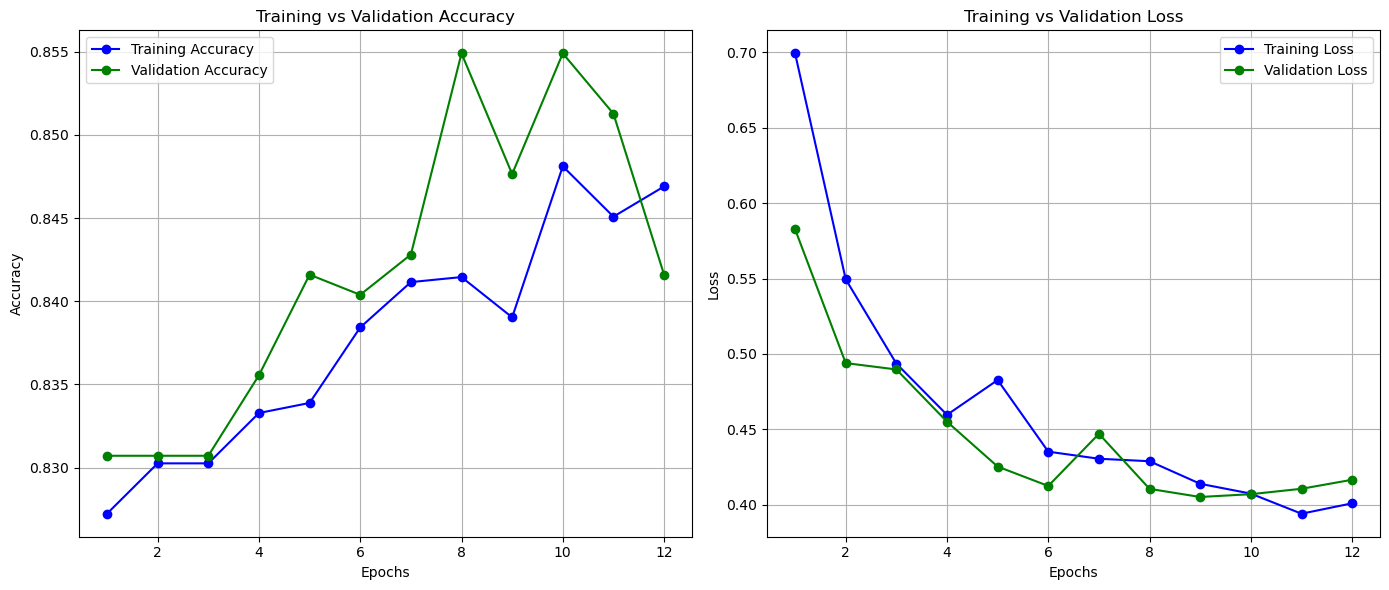

In [698]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Predicting Skin Lesion from a User-Provided Image

In this section, we demonstrate how the trained model can be used to predict the type of skin lesion for a given image. This simulates a real-world scenario where a user uploads an image and receives a diagnostic prediction.

The process involves:

1. **Loading the Model**:  
   The previously trained and saved CNN model (`skin_lesion_classifier.keras`) is loaded using Keras' `load_model()`.

2. **Image Preprocessing**:  
   The input image is resized to `128x128`, normalized (divided by 255), and reshaped to match the model's expected input format `(1, 128, 128, 3)`.

3. **Prediction**:  
   The model outputs probability scores for each class, from which the class with the highest probability is selected using `argmax()`.

4. **Visualization**:  
   The predicted class name and confidence score are displayed, along with the actual input image for visual confirmation.

In [709]:
model = load_model("skin_lesion_classifier.keras")

# Class label map
class_names = ['nv', 'mel', 'bcc']  # order used during label encoding

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    
    pred = model.predict(img_array)[0]
    class_index = np.argmax(pred)
    confidence = pred[class_index]
    
    print(f"Prediction: {class_names[class_index]} ({confidence:.2f})")
    
    # Show the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{class_names[class_index]} ({confidence:.2f})")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Prediction: nv (1.00)


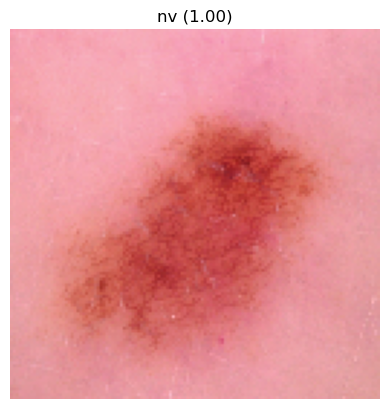

In [710]:
predict_image("C:/Users/Muhammad Haris/Contacts/Machine Learning/Neural Network/HAM10000_images_part_1/ISIC_0024311.jpg")


## Model Saved

In [706]:
model.save('skin_lesion_classifier.keras')


## Ground Truth Verification

To ensure that the model's prediction is correct, we compare the predicted class with the actual label (ground truth) from the metadata CSV file.

#### How It Works:

1. **Load Metadata**:  
   We load the `HAM10000_metadata.csv` file which contains mappings between each image ID and its corresponding diagnosis (`dx` column).

2. **Extract Ground Truth**:  
   Using the `image_id` of the image we made a prediction on, we filter the dataframe to get the actual diagnosis.

3. **Compare Prediction vs Ground Truth**:  
   If the predicted class matches the true label, we consider it a correct prediction.


In [711]:
metadata = pd.read_csv("HAM10000_metadata.csv")

image_id = "ISIC_0024311"
true_label = metadata.loc[metadata['image_id'] == image_id, 'dx'].values[0]

print(f"Ground Truth Label: {true_label}")

predicted_class = "nv"

if predicted_class == true_label:
    print(" Correct Prediction!")
else:
    print(" Incorrect Prediction.")


Ground Truth Label: nv
 Correct Prediction!
